# Rhynie Chert Metanetwork and SLNs #
# Adapted from "Analytical approaches to networks, trophic structure, and ancient food webs" #
# NAPC 2024 #

A metanetwork is a higher level of network organization wherein species are aggregated into sets, with members or elements of a set sharing overlapping or nested sets of prey and predators (Roopnarine et al., 2007). It is not uncommon for extant species to be aggregated, when constructing food webs of modern communities, into sets where members share exactly the same predators and prey. Those sets are termed trophospecies (Yodzis, 1988) or trophic species, but although it is entirely possible that two species could share exactly the same prey and predators, especially for very specialized species with few interactions or species belonging to communities of very low species richness, it must surely be more likely that trophospecies represent limits to the precision with which the interactions have been documented.

## Trophic guilds ##
The metanetwork approach aggregates species on the basis of shared body size ranges, habitat, temporal distribution, and inferences of probable prey and predators belong to the rest of the taxon assemblage. The aggregated groups are referred to as trophic guilds (Roopnarine, 2010), both to distinguish them from trophospecies and to note their correspondence to ecological guilds, although more narrowly defined than is typical of guilds. All trophospecies are subsets of trophic guilds, because the latter are formed from a relaxation of the assumption that members of a trophospecies are trophically identical. Here are the basic rules for constructing trophic guilds.
1. Species within a trophic guild need not have identical interactions, but their interactions are all drawn from the same set. 
2. No two trophic guilds in a metanetwork may have interactions drawn from the same sets; in such an instance the two groups are actually the same single trophic guild (Liebniz's Law, or identity of indiscernibles). 
3. Resist the temptation to construct trophic guilds that differ in taxonomic or phylogenetic composition only. For example, constructing two trophic guilds consisting of medium body sized carnivorous diapsids and synapsids that belonged to the same paleocommunity, and that to the best of our knowledge preyed on the same taxa and were subject to the same predators, would violate the metanetwork concept. The division is ecologically unnecessary.

A metanetwork is complete when interactions are specified between trophic guilds. The interactions indicate which guilds comprise species that could be prey or predators of any particular guild.

### Rhynie network ###
The following metanetwork consists of two files. The first lists and names the trophic guilds, along with the taxon richness of each guild and an assumption of its trophic habit (e.g. "producer"). Note that all guilds have been labelled as type "producer", which is obviously an error. This is intentional and will be corrected in a later section. The second file is the metanetwork adjacency matrix, which is a binary $\vert U\vert\times \vert U\vert$ matrix, where $\vert U\vert$ is the total number of guilds in the metanetwork, $U$. The entries in this matrix are 0 or 1. If guild $G_i$ contains species hypothesized to prey on some or all those in guild $G_j$, then the $ij^{th}$ entry is 1, and zero otherwise.

### Code note ###
Note that much of the code and software written by Peter Roopnarine for working with metanetworks, constructing species-level food webs, calculating their metrics and simulating their dynamics, have been written using the Julia programming language. You must have Julia installed on your system to operate the code, and the Jupyter notebook environment installed for Julia. Helpful links are:

https://julialang.org/

https://jupyter.org/

The following blocks of code are therefore all Julia. The code is licensed with the GNU General Protection License which, if you are not familiar with (but you should be!), allows users to freely reuse, modify and redistribute the original code. But please familiarize yourself with the obligations and restrictions of the license.

In [35]:
# load necessary Julia libraries
# these must be installed via the Julia repl or terminal environment. Do so with the following commands
# using Pkg
# Pkg.add("CSV")
using CSV,DelimitedFiles,DataFrames,Random,Distributions,StatsPlots,LinearAlgebra,PoissonRandom,Graphs,GraphPlot,Colors

In [36]:
# also load these library functions written for the SLN family of code
include("./SLN_maker.jl")
include("./r_no_prey.jl")

r_no_prey (generic function with 1 method)

### File input ###
Read the metanetwork and adjacency matrix files and print the metanetwork as a simple file check. Here we are using one of the PTB files.

In [434]:
P = CSV.read("guilds.csv",DataFrame)
A = readdlm("guild_matrix.csv")
print(P)

iter = 10 #for file naming
analysis_type = "terr_only" #complete, terr_only, or aqu_only

"terr_only"

Note that the first several guilds are "producer" guilds, including detritus.

Also note that all the guilds are listed as trophic type "producer". We correct this in the following.

In [416]:
# check trophic positions and modify if necessary
# transpose A
A_t = transpose(A)
for i = 1:size(P,1)
    vA = sum(A[i,:],dims=1)
    vA_t = sum(A_t[i,:],dims=1)
    if vA[1]==0
        P[i,:sp_tp] = "producer"
    end
    if vA[1]!=0
        if vA_t[1]!=0
            P[i,:sp_tp] = "consumer"
        end
        if vA_t[1]==0
            P[i,:sp_tp] = "apex"
        end
    end
end
print(P)

### Summary statistics ###
Calculate the total number of guilds and total guild richness $S$, nominally the number of species.

Also, create subsets of the main web separating aquatic and terrestrial components

In [417]:
# calculate metanetwork diversity
#no. of guilds
no_guilds = size(P,1)
println("\nNo. of guilds, G = ", no_guilds)
#calculate number of species
S = sum(P[:,:G])
no_species = S[1]
println("No. of species, S = ", no_species)

## Make subset for terrestrial-only web
guilds_terr = findall(==(1),P[:,5])
P_terr = P[guilds_terr,:]
A_t_terr = A_t[guilds_terr,guilds_terr]
no_guilds_terr = size(P_terr, 1)
println("\nNo. of terrestrial guilds: ", no_guilds_terr)
S_terr = sum(P_terr[:,:G])
no_species_terr = S_terr[1]
println("No. of terrestrial species = ", no_species_terr)

## Make subset for aquatic-only web
guilds_aqu = findall(==(1),P[:,6])
P_aqu = P[guilds_aqu,:]
A_t_aqu = A_t[guilds_aqu,guilds_aqu]
no_guilds_aqu = size(P_aqu, 1)
println("\nNo. of aquatic guilds: ", no_guilds_aqu)
S_aqu = sum(P_aqu[:,:G])
no_species_aqu = S_aqu[1]
println("No. of aquatic species = ", no_species_aqu)

### Metanetwork visualization ###
A completely unnecessary bit of bling, but always nice to see. Producer guilds are green, intermediate consumers are orange, and apex consumers are red.

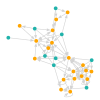

In [418]:
# plot the metanetwork
G=DiGraph(A_t)
nvertices = nv(G) # number of vertices
node_type = Int64[]
for i = 1:size(P,1)
    if P[i,:sp_tp]=="producer"
        push!(node_type,1)
    elseif P[i,:sp_tp]=="consumer"
        push!(node_type,2)
    elseif P[i,:sp_tp]=="apex"
        push!(node_type,3)
    end
end

# membership color
nodecolor = [colorant"lightseagreen", colorant"orange", colorant"red"]
nodefillc = nodecolor[node_type];

gplot(G,layout=spring_layout,nodefillc=nodefillc)

## SLN construction ##

The next series of cells estimate a single SLN (species-level network or food web) from the metanetwork. Some of the code consists of essential algorithmic steps, but the general procedure is as follows:
1. Calculate the maximum number of potential prey species or nodes for each consumer. This is the sum richness of all the guilds that are linked as resources or prey, in the metanetwork, to a guild $G_i$. Designate this sum as $M_i = \sum_j^{\vert U\vert}a_{ij}\vert G_j\vert$.
2. Generate the specific number of prey species or resource nodes of a species in guild $G_i$. This depends on a stochastic draw from an in-degree distribution, which can be a hypothetical, model, or empirically determined distribution. Here we use a mixed exponential-power law distribution. Use of this distribution requires a parameter, $\gamma$, describing the thickness of the distribution's tail. The stochastic draw is done using the function "r_no_prey.jl", but it is quite easy to substitute another function using Julia's Distributions package. See https://juliastats.org/Distributions.jl/stable/starting/
3. When the number of prey, or in-degree of a species has been so determined, the actual prey species are then determined by assigning the number of links randomly to species within the prey guilds.

In [419]:
# calculate no. of prey species per guild
P[:,:no_prey] .= 0.0
P[:,:no_preds] .= 0.0
for i = 1:no_guilds
	  for j = 1:no_guilds
	      if A[i,j] == 1
	          P[i,:no_prey] = P[i,:no_prey] + P[j,:G]
	      end
        if A[j,i] == 1
	          P[i,:no_preds] = P[i,:no_preds] + P[j,:G]
	      end
	  end
end
print(P)

In [420]:
# construct guild x species array
meta_SLN = SLN_maker(A,P,no_guilds,no_species);

set $\gamma$, the power law parameter.

Specify a number of replicate SLNs to generate.

In [421]:
γ = 3

n_replicates = 100

100

Construct an empty table (dataframe) for the species data.

In [422]:
# dataframe for species data
species = DataFrame(sp_name = Int64[], guild = String[], guild_no = Int64[], g_richness = Int64[], g_no_prey = Int64[], sp_no_prey = Int64[], sp_no_preds = Int64[], sp_long_chain = Int64[], sp_ntp = Float64[])

Row,sp_name,guild,guild_no,g_richness,g_no_prey,sp_no_prey,sp_no_preds,sp_long_chain,sp_ntp
,Int64,String,Int64,Int64,Int64,Int64,Int64,Int64,Float64


Create the SLN as a species-level consumer-resource binary adjacency matrix of dimensions $S\times S$.

In [423]:
# push guild data
begin
    tally1 = [1]
    for i = 1:no_guilds
        guild_richness = P[i,:G]
        for j = 1:guild_richness
            push!(species, [tally1[1], P[i,:Guild], i, P[i,:G], P[i,:no_prey], 0, 0, 0, 0])
            tally1[1] = tally1[1] + 1
        end
    end
end
    
# initial species no. of prey; uses in-degree distribution
for i = 1:size(species,1)
    species[i,:sp_no_prey] = r_no_prey(species[i,:g_no_prey],γ)
end
    
# select species-specific prey and generate species A matrix
sp_A = zeros(Int64,no_species,no_species)
for i = 1:no_species
    #vector of species prey indices
    guild_prey = Int64[]
    for j = 1:no_species
        if meta_SLN[species[i,:guild_no],j] == 1
            push!(guild_prey,j)
        end
    end
    #randomize prey vector
    shuffle!(guild_prey)
    #pick species prey and predators
    for k = 1:species[i,:sp_no_prey]
        sp_A[i,guild_prey[k]] = 1
    end
end

#calculate no. preds, or out-degree
for i = 1:no_species
    out_degree = 0
    for j = 1:no_species
        if sp_A[j,i] == 1
            out_degree += 1
        end
    end
    species[i,:sp_no_preds] = out_degree
end


The SLN matrix is a sparse matrix (i.e. most of the elements are zero), as are all realistic and real world food web matrices, so there isn't much point in printing it. But we can visualize the resulting graph (network).

In [424]:
# plot the metanetwork
sp_A_t = transpose(sp_A)
G2=DiGraph(sp_A_t)
nvertices = nv(G2) # number of vertices

gplot(G2,layout=spring_layout)

adj_matrix = adjacency_matrix(DiGraph(sp_A))
df = DataFrame(adj_matrix, :auto)
#save adjacency matrix
CSV.write("output/complete/SLN_matrix_$(iter).csv", df)

"output/complete/SLN_matrix_10.csv"

Given this matrix, we can now compute several network metrics, namely:
1. The total number of interactions, $L$.
2. Link density, or the average number of interactions per species. 
$$L_D = \frac{L}{S}$$
3. Connectance, the ratio of the number of interactions to the number of interactions possible given $S$.
$$C = \frac{L}{S(S-1)}$$

In [425]:
SLN_stats_out = DataFrame(interactions = Float64[], L_D = Float64[], C = Float64[])
# no. of interactions
no_interactions = sum(sp_A)
# link density
Ld = no_interactions/no_species
# connectance
C = no_interactions/(no_species*(no_species-1))
push!(SLN_stats_out,[no_interactions,Ld,C])


# Omnivores: fraction of consumer species that eat basal species + consumers
# Carnivores: fraction of consumer species that eat other consumers
# Trophic Omnivory: fraction of consumer species that eat across trophic levels

# mean in-degree for consumers (generality)

# mean shortest chain length
# PathSD: standard dev. of path lengths

# trophic coherence [Johnson et al 2014] ... in progress

Row,interactions,L_D,C
,Float64,Float64,Float64
1,272.0,2.74747,0.0280355


Add a column for Herbivores

In [426]:
#Herbivores: fraction of consumer species that eat only basal species

# Step 1: Identify basal species (no incoming links)
is_basal = [sum(sp_A[i, j] for j in 1:nvertices) == 0 for i in 1:nvertices]

# Step 2–3: For each consumer species, check if it only eats basal species
herbivores = 0
consumers = 0

for i in 1:nvertices
    prey = findall(sp_A[i, :] .== 1)
    if !isempty(prey)
        consumers += 1
        if all(is_basal[j] for j in prey)
            herbivores += 1
        end
    end
end

Herbiv = herbivores/consumers
SLN_stats_out.Herbiv = [Herbiv] #replace this with a push! when you make it a loop
SLN_stats_out

Row,interactions,L_D,C,Herbiv
,Float64,Float64,Float64,Float64
1,272.0,2.74747,0.0280355,0.6


Add a column for Omnivores

In [427]:
# Omnivores: fraction of consumer species that eat both basal species + consumers

# Step 1: Identify basal species (no incoming links)
is_basal = [sum(sp_A[i, j] for j in 1:nvertices) == 0 for i in 1:nvertices]

# Step 2: For each consumer, check if they eat both basal and consumer prey
omnivores = 0
consumers = 0

for i in 1:nvertices
    prey = findall(sp_A[i, :] .== 1)

    if !isempty(prey)
        consumers += 1
        has_basal = any(is_basal[j] for j in prey)
        has_consumer = any(!is_basal[j] for j in prey)

        if has_basal && has_consumer
            omnivores += 1
        end
    end
end

Omniv = omnivores/consumers
SLN_stats_out.Omniv = [Omniv] #replace this with a push! when you make it a loop
SLN_stats_out

Row,interactions,L_D,C,Herbiv,Omniv
,Float64,Float64,Float64,Float64,Float64
1,272.0,2.74747,0.0280355,0.6,0.171429


Add a column for Carnivores

In [428]:
# Carnivores: fraction of consumer species that eat other consumers

# Step 1: Identify basal species
is_basal = [sum(sp_A[i, j] for j in 1:nvertices) == 0 for i in 1:nvertices]


carnivores = 0
consumers = 0

for i in 1:nvertices
    prey = findall(sp_A[i, :] .== 1)

    if !isempty(prey)
         consumers += 1
         if all(!is_basal[j] for j in prey)
             carnivores += 1
         end
     end
end



Carniv = carnivores/consumers
SLN_stats_out.Carniv = [Carniv] #replace this with a push! when you make it a loop
SLN_stats_out

Row,interactions,L_D,C,Herbiv,Omniv,Carniv
,Float64,Float64,Float64,Float64,Float64,Float64
1,272.0,2.74747,0.0280355,0.6,0.171429,0.228571


And finally, we may now complete the species data with the calculation of two additional species properties of ecological interest, the length of the longest path between the species and a primary producer, and the network trophic level.

Network trophic level, or ntp, is a measure of the average number of steps or links between a taxon and primary producers. By definition, primary producers will be of ntp 1, primary consumers (e.g. herbivores) will be of ntp 2, and secondary consumers will be of greater ntp. It is calculated as the average of the shortest distances between a taxon's prey and a primary producer.
$$\textrm{ntp}_i = 2 + \frac{1}{k_i}\sum_{j=1}^S a_{ij}d_{j}$$
where $k_i$ is the number of prey of taxon $i$, $a_{ij}$ is the binary indicator of whether taxon $i$ preys on taxon $j$, and $d_j$ is the shortest distance, or number of links, between taxon $j$ and a primary producer.

Calculation of ntp is a bit involved (see length of code block below), as it requires raising the adjacency matrix to successively greater powers to determine pathways among species.

In [429]:
#initialize pathways matrix
    paths = Array{Int64}(undef,no_species,no_species)
    paths = deepcopy(sp_A)
    #longest possible pathway
    P_max = no_guilds - 1
    #set initial longest path for each species
    for i = 1:no_species
        if species[i,:sp_no_prey] > 0
            species[i,:sp_long_chain] = 1
        end
    end
    
    #calculate pathways by raising binary adjacency matrix to pathway lengths
    for i = 1:P_max
        A2 = sp_A^i
        for j = 1:no_species
            for k = 1:no_species
                #if path now exists between species
                if paths[j,k]==0 && A2[j,k]>0
                    #update the pathways matrix
                    paths[j,k] = i
                end
            end
            #list as longest chain if one exists
            if sum(paths[j,:]) != 0
                species[j,:sp_long_chain] = maximum(paths[j,:])
            end
        end       
        if sum(A2)==0
            break
        end
    end
    
    #calculate ntps
    #build vector of primary producers
    prods = Int64[]
    for i = 1:no_species
        if species[i,:sp_no_prey] == 0
            push!(prods,i)
        end
    end
    #calculate path length of prey to producers
    for i = 1:no_species
        #if producer
        if species[i,:sp_no_prey]==0
            species[i,:sp_ntp] = 1
        elseif species[i,:sp_no_prey]>0
            #else if consumer
            #list prey
            its_prey = Int64[]
            path_length = 0
            no_paths = 0
            for j = 1:no_species
                #if species is producer prey of i
                if paths[i,j] == 1 && species[j,:sp_no_prey] == 0
                    no_paths+=1
                end
                #if species is consumer prey of i
                if paths[i,j] == 1 && species[j,:sp_no_prey] > 0
                    #record path lengths to producers
                    for k = 1:no_species
                        if paths[j,k]!=0 && species[k,:sp_no_prey]==0
                            path_length = path_length + paths[j,k]
                            no_paths+=1
                        end
                    end
                end 
            end
            #if herbivore
            if path_length==0
                species[i,:sp_ntp] = 2.0
            elseif path_length > 0
                #if not herbivore
                species[i,:sp_ntp] = 2.0 + (Float64(path_length)/Float64(no_paths))
                #println(species[i,6])
            end
        end
    end

In [430]:
CSV.write("output/complete/SLN_$(iter).csv", species)
print(species)

Now we add a few more stats to the SLN_stats_out dataframe: mean Trophic position, normalized mean trophic position (by max trophic position), Trophic Omnivory (how many species eat at multiple trophic levels), and mean in-degree

In [431]:
#Trophic Omnivory: fraction of consumer species that eat across trophic levels
num_integers = count(x -> isfinite(x) && x % 1 == 0, species.sp_ntp)
trophic_omnivores = nvertices - num_integers
TrOmniv = trophic_omnivores/nvertices
SLN_stats_out.TrOmniv = [TrOmniv] #replace this with a push! when you make it a loop

#mean net trophic position
mean_NTP = mean(species.sp_ntp)
SLN_stats_out.mean_NTP = [mean_NTP] #replace this with a push! when you make it a loop

#normalized mean net trophic position (divide by max value of ntp)
mean_NTP_norm = mean_NTP / maximum(species.sp_ntp)
SLN_stats_out.mean_NTP_norm = [mean_NTP_norm] #replace this with a push! when you make it a loop

#mean in-degree (in-degree = generality = number of prey species)
mean_InDegree = mean(species.sp_no_prey)
SLN_stats_out.mean_InDegree = [mean_InDegree] #replace this with a push! when you make it a loop

SLN_stats_out

Row,interactions,L_D,C,Herbiv,Omniv,Carniv,TrOmniv,mean_NTP,mean_NTP_norm,mean_InDegree
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,272.0,2.74747,0.0280355,0.6,0.171429,0.228571,0.20202,2.10402,0.414428,2.74747


and mean path length

In [ ]:
# Compute all-pairs shortest paths
all_paths = floyd_warshall_shortest_paths(SimpleDiGraph(sp_A))

# Extract all finite path lengths
lengths = Float64[]
for i in 1:nvertices
     for j in 1:nvertices
         d = all_paths.dists[i, j]
        if i != j && (d) < 100000
            push!(lengths, d)
        end
    end
end

mean_path_len = mean(lengths)
stdev_path_len = std(lengths)

SLN_stats_out.mean_path_len = [mean_path_len] #replace this with a push! when you make it a loop
SLN_stats_out.stdev_path_len = [stdev_path_len] #replace this with a push! when you make it a loop
SLN_stats_out

#write the web stats to a .csv
CSV.write("output/complete/SLN_metrics_$(iter).csv", SLN_stats_out)


"output/complete/SLN_metrics_10.csv"

The species food web is now available for further analyses or simulations. The species properties themselves can also be analyzed. Here they are simply visualized for you.

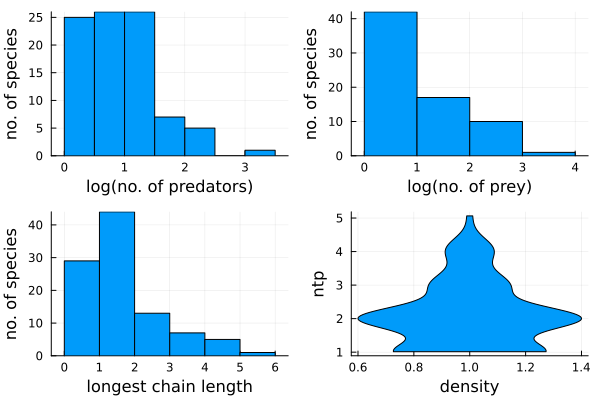

In [433]:
log_out_degree = Float64[]
log_in_degree = Float64[]
for i = 1:size(species,1)
    push!(log_out_degree,log(species[i,"sp_no_preds"]))
    push!(log_in_degree,log(species[i,"sp_no_prey"]))
end

p1 = histogram(log_out_degree,xlabel="log(no. of predators)",ylabel="no. of species")
p2 = histogram(log_in_degree,xlabel="log(no. of prey)",ylabel="no. of species")
p3 = histogram(species[:,:sp_long_chain],xlabel="longest chain length",ylabel="no. of species")
p4 = violin(species[:,:sp_ntp],xlabel="density",ylabel="ntp")
plot(p1,p2,p3,p4,legend=false)